# Model Implementation

After we have made the necessary preprocessing to our dataset. It's time now to select the best model for the problem of predicting home loan default risk. 
Let's try different classification models and select the best out of them

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt       # Standard plotting library
from time import time

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('data/application_train_final.csv')#application_train_final.csv')
# Success - Display the first record  
data.head(n=5)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_-999,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0.0,0.244311,0.486854,0.519304,0.468102,0.018801,0.102041,0.001,...,0,0,0,0,0,1,0,0,1,0
1,100003,0,0.0,0.278657,0.745153,0.594277,0.722032,0.003541,0.510204,0.003,...,1,0,0,0,0,0,0,0,1,0
2,100004,0,0.0,0.114293,0.242071,0.257575,0.261059,0.010032,0.653061,0.000,...,0,0,0,0,0,0,0,1,0,0
3,100006,0,0.0,0.196694,0.428211,0.556790,0.431844,0.008019,0.653061,0.008,...,0,0,0,0,0,0,0,1,0,0
4,100007,0,0.0,0.183780,0.538977,0.493021,0.550527,0.028663,0.693878,0.008,...,0,0,0,0,0,0,0,1,0,0


In [36]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split target and features data
target = data['TARGET']
data = data.drop('TARGET', axis = 1)
data = data.drop('SK_ID_CURR', axis = 1) # Remove application id from features
data.shape[0]
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size = 0.3, 
                                                    random_state = 48)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 215054 samples.
Testing set has 92166 samples.


### Model Performance 

The purpose of this project is to minimize the risk of home loan dafualt risk. The dataset given to perform the prediction contains imbalanced class, e.g. the number of default loans compared to successful loan payment number is high. Therefore, accuracy metric could be misleading as some of the classification models outweight the dominant class and will always predict the dominant class. Since the purpose of this project is to minimze the risk, it would be better to reject an applicant that has been classified as default but they appear not (False Positive) than calssifying a default to be successful payment. In other words, it is better to focus on minimzing false negative rate than false positive rate. This suggests to use either Recall, Precision, and/or Area Under the Curve (AUC) for evaluating the model.

In [37]:
TP = np.sum(target) # Counting the ones as this is the naive case. 
FP = target.count() - TP # Specific to the naive case

TN = 0.0 # No predicted negatives in the naive case
FN = 0.0 # No predicted negatives in the naive case

accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP) * 1.0

beta = 0.5
fscore = (1.0 + (beta**2.0)) * ((precision * recall) / ((beta**2.0 * precision) + recall))


# Print the results 
print("Naive Predictor: [Accuracy score: {:.04}, F-score: {:.04}, Recall: {:.04}, Precision: {:.04}]".format(accuracy, fscore, recall, precision))


Naive Predictor: [Accuracy score: 0.08074, F-score: 0.09892, Recall: 1.0, Precision: 0.08074]


In [38]:
def get_scores(y_train, y_test, y_pred_train, y_pred_test):
    res = {}
    res['acc_train'] = accuracy_score(y_train, to_binary(y_pred_train.copy()))
    res['acc_test'] = accuracy_score(y_test, to_binary(y_pred_test.copy()))

    res['f_train'] = fbeta_score(y_train, to_binary(y_pred_train.copy()), beta=0.5)
    res['f_test'] = fbeta_score(y_test, to_binary(y_pred_test.copy()), beta=0.5)

    res['rec_train'] = recall_score(y_train, to_binary(y_pred_train.copy()))
    res['rec_test'] = recall_score(y_test, to_binary(y_pred_test.copy()))

    res['pre_train'] = precision_score(y_train, to_binary(y_pred_train.copy()))
    res['pre_test'] = precision_score(y_test, to_binary(y_pred_test.copy()))

    res['auc_train'] = roc_auc_score(y_train, y_pred_train)        
    res['auc_test'] = roc_auc_score(y_test, y_pred_test)
    return res

In [39]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, roc_auc_score

# convert probability to binary for LighGBM 
def to_binary(y_pred):
    for i in range(0, len(y_pred)):
        if y_pred[i] >= .5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    return y_pred

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    res = {}

    if learner[0] == 'LightGBM':
        lgb_train = lgb.Dataset(data=X_train,label=y_train)
        learner = lgb.train(learner[1], lgb_train, 10)

    # Fit the learner to the training data using .fit(training_features, training_labels)
    else:
        learner = learner[1].fit(X_train, y_train)
    
    predictions_train = learner.predict(X_train)
    predictions_test = learner.predict(X_test)
    
    res = get_scores(y_train, y_test, predictions_train, predictions_test)
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(X_train)))
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, to_binary(predictions_test.copy())).ravel()    
    print("TN: {:}, FP: {:}, FN:{:}, TP:{:}".format(tn, fp, fn, tp))
    # Return the results
    return res


In [40]:
#Import classification models, gridSearch, and evaluation metrics from sklearn
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [42]:
pos_class = target.count()//np.sum(target)
classifiers = [
    ('ABoost', AdaBoostClassifier(random_state=48)),
    ('GNB', GaussianNB()),
    ('LR', LogisticRegression(random_state=48, class_weight='balanced')),
    ('XGBoost', XGBClassifier(random_state=48, scale_pos_weight=pos_class)),
    ('LightGBM', { 'objective': 'binary', 
                  'metric': 'auc', 
                  'scale_pos_weight': pos_class,
                  'random_state': 48}) # passing parameters only for LightGBM 
]

results = {}

for classifier in classifiers:
    print("Started training", classifier[0], "model")
    res = train_predict(classifier, X_train, y_train, X_test, y_test)
    results[classifier[0]] = res
    print("Train - AUC: {:.04}, Accuracy: {:.04}, f1 score: {:.04}, Recall: {:.04}, Precision: {:.04}".format(
        res["auc_train"], res["acc_train"], res["f_train"], res["rec_train"], res["pre_train"])
         )
    print("Pred - AUC: {:.04}, Accuracy: {:.04}, f1 score: {:.04}, Recall: {:.04}, Precision: {:.04}".format(
        res["auc_test"], res["acc_test"], res["f_test"], res["rec_test"], res["pre_test"])
         )
    print("\n")


Started training ABoost model
AdaBoostClassifier trained on 215054 samples.
TN: 84701, FP: 9, FN:7449, TP:7
Train - AUC: 0.5002, Accuracy: 0.9193, f1 score: 0.002008, Recall: 0.0004035, Precision: 0.3333
Pred - AUC: 0.5004, Accuracy: 0.9191, f1 score: 0.004654, Recall: 0.0009388, Precision: 0.4375


Started training GNB model
GaussianNB trained on 215054 samples.
TN: 7849, FP: 76861, FN:440, TP:7016
Train - AUC: 0.5199, Accuracy: 0.1632, f1 score: 0.1026, Recall: 0.9453, Precision: 0.08392
Pred - AUC: 0.5168, Accuracy: 0.1613, f1 score: 0.1023, Recall: 0.941, Precision: 0.08365


Started training LR model
LogisticRegression trained on 215054 samples.
TN: 54151, FP: 30559, FN:2729, TP:4727
Train - AUC: 0.6325, Accuracy: 0.6363, f1 score: 0.1565, Recall: 0.6279, Precision: 0.1318
Pred - AUC: 0.6366, Accuracy: 0.6388, f1 score: 0.1591, Recall: 0.634, Precision: 0.134


Started training XGBoost model


/Users/omar/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/omar/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier trained on 215054 samples.
TN: 56473, FP: 28237, FN:2214, TP:5242
Train - AUC: 0.6921, Accuracy: 0.6691, f1 score: 0.1877, Recall: 0.7194, Precision: 0.1584
Pred - AUC: 0.6849, Accuracy: 0.6696, f1 score: 0.1854, Recall: 0.7031, Precision: 0.1566


Started training LightGBM model
Booster trained on 215054 samples.
TN: 77074, FP: 7636, FN:5062, TP:2394
Train - AUC: 0.7486, Accuracy: 0.8635, f1 score: 0.2576, Recall: 0.3304, Precision: 0.2442
Pred - AUC: 0.7364, Accuracy: 0.8622, f1 score: 0.2516, Recall: 0.3211, Precision: 0.2387




In [43]:
accuracy = [{model:results[model]["acc_test"]} for model in results]
recall = [{model:results[model]["rec_test"]} for model in results]
precision = [{model:results[model]["pre_test"]} for model in results]
auc = [{model:results[model]["auc_test"]} for model in results]
f1 = [{model:results[model]["f_test"]} for model in results]

In [44]:
accuracy = dict(pair for d in accuracy for pair in d.items())
recall = dict(pair for d in recall for pair in d.items())
precision = dict(pair for d in precision for pair in d.items())
auc = dict(pair for d in auc for pair in d.items())
f1 = dict(pair for d in f1 for pair in d.items())

In [45]:
def plot(x_label, y_label, dic):
    plt.bar(range(len(dic)), list(dic.values()), align='center')
    plt.xticks(range(len(dic)), list(dic.keys()), rotation=90)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()

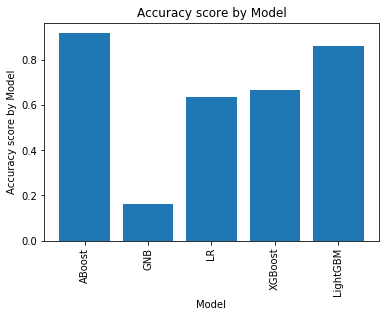

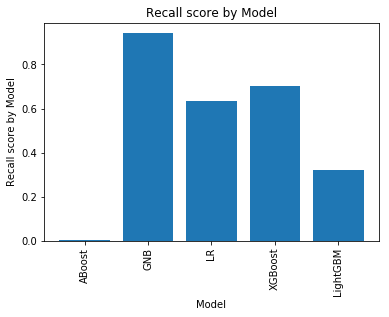

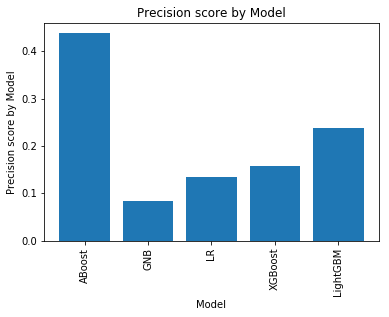

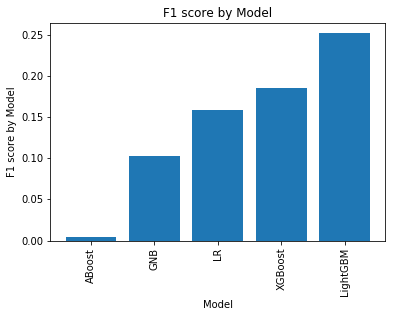

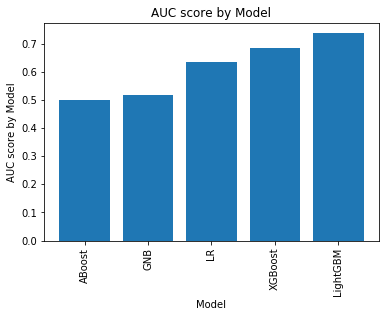

In [46]:
plot('Model','Accuracy score by Model', accuracy)
plot('Model','Recall score by Model', recall)
plot('Model','Precision score by Model', precision)
plot('Model','F1 score by Model', f1)
plot('Model','AUC score by Model', auc)

Since the dataset is an imbalanced dataset (only 8% of dataset classified as positive), LightGBM and XGBoost performs the best out of the other models used above in terms of F1 score and AUC score. Therefore, the chosen model for this problem will be LightGBM model. 

# Parameters Tuning

In [47]:
print('LightGBM AUC score before tuning: {:.04}, F1 Score: {:.04}'.format(auc['LightGBM'], f1['LightGBM']))

LightGBM AUC score before tuning: 0.7364, F1 Score: 0.2516


In the following steps, the aim is to increase both AUC and F1 score for LightGBM model by tuning its hyperparameter to find the best parameters that fits the dataset optimally.

In [48]:
# para searching
params = {
    'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
    'objective': 'binary',
    'metric': ['auc', 'f1'], 
    
    'learning_rate': 0.1,
    
    'num_leaves': np.random.randint(64, 128),
    'max_depth': np.random.randint(6, 12),
    'min_data_in_leaf': int(2 ** (np.random.rand()*3.5 + 9)),
    
    'feature_fraction': np.random.rand()*0.35+0.65,
    'bagging_fraction': np.random.rand()*0.35+0.65,
    'bagging_freq': 1,
    
    'lambda_l1': 10 ** (np.random.rand() * 4),
    'lambda_l2': 10 ** (np.random.rand() * 3 + 2),
    'min_gain_to_split': 0.0,
    'min_sum_hessian_in_leaf': 0.1,
    
    'num_threads': 16,
    'verbose': 0,
    'is_training_metric': 'True',
    'scale_pos_weight': pos_class
}

evals_result = {}  # dict to store evaluation results of all the items in `valid_sets`
dev_X, val_X, dev_y, val_y = train_test_split(X_train, 
                                              y_train, 
                                              test_size = 0.2, 
                                              random_state = 42) # split training dataset into train and validation
pos_class = dev_y.count()//np.sum(dev_y) # recalculate positive class weight after CV split

lgb_train = lgb.Dataset(data=dev_X,label=dev_y) # training dataset
lgb_val = lgb.Dataset(data=val_X, label=val_y) # validation dataset
lgb_test = lgb.Dataset(data=X_test,label=y_test) # testing dataset

gbm = lgb.train(params, lgb_train, 5000, valid_sets=[lgb_val], \
                valid_names = ['cv'], evals_result=evals_result, \
                early_stopping_rounds=250, verbose_eval=100, 
                categorical_feature='auto')
predictions_test_tuned = gbm.predict(X_test)


Training until validation scores don't improve for 250 rounds.
[100]	cv's auc: 0.748713
[200]	cv's auc: 0.756333
[300]	cv's auc: 0.758795
[400]	cv's auc: 0.759729
[500]	cv's auc: 0.760118
[600]	cv's auc: 0.760068
[700]	cv's auc: 0.760237
[800]	cv's auc: 0.75999
[900]	cv's auc: 0.759756
Early stopping, best iteration is:
[702]	cv's auc: 0.760281


In [29]:
print('Best Parameters that improved our final model LightGBM: \n{}'.format(params))

Best Parameters that improved our final model LightGBM: 
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['auc', 'f1'], 'learning_rate': 0.1, 'num_leaves': 116, 'max_depth': 7, 'min_data_in_leaf': 2394, 'feature_fraction': 0.8480511816917773, 'bagging_fraction': 0.7682161532143479, 'bagging_freq': 1, 'lambda_l1': 134.29783711684772, 'lambda_l2': 3105.4418845715327, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 0.1, 'num_threads': 16, 'verbose': 0, 'is_training_metric': 'True', 'scale_pos_weight': 12}


In [30]:
res_tuned = get_scores(y_train, y_test, predictions_train, predictions_test_tuned)
print('Before Tuning:\nAUC score: {:.04}, F1 Score: {:.04}, Recall: {:.04}, Precision: {:.04}'.format(auc['LightGBM'], f1['LightGBM'], recall['LightGBM'], precision['LightGBM']))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, to_binary(predictions_test.copy())).ravel()    
print("TN: {:}, FP: {:}, FN:{:}, TP:{:}".format(tn, fp, fn, tp))

print('\nAfter Tuning:\nAUC score: {:.04}, F1 Score: {:.04}, Recall: {:.04}, Precision: {:.04}'.format(res_tuned['auc_test'], res_tuned['f_test'], res_tuned['rec_test'], res_tuned['pre_test']))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, to_binary(predictions_test_tuned.copy())).ravel()    
print("TN: {:}, FP: {:}, FN:{:}, TP:{:}".format(tn, fp, fn, tp))

Before Tuning:
AUC score: 0.7364, F1 Score: 0.2516, Recall: 0.3211, Precision: 0.2387
TN: 77074, FP: 7636, FN:5062, TP:2394

After Tuning:
AUC score: 0.7596, F1 Score: 0.196, Recall: 0.6943, Precision: 0.1662
TN: 58734, FP: 25976, FN:2279, TP:5177


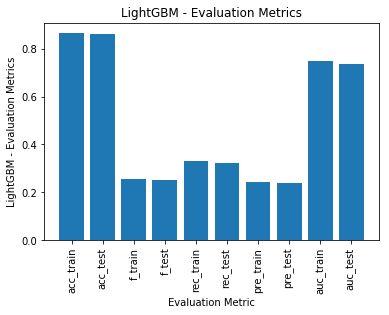

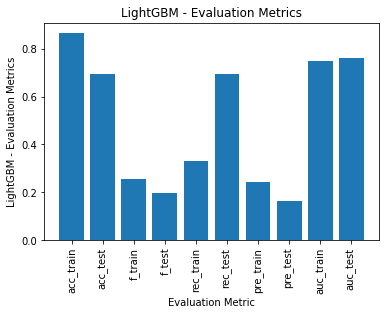

In [32]:
plot('Evaluation Metric','LightGBM - Evaluation Metrics', results['LightGBM'] )
plot('Evaluation Metric','LightGBM - Evaluation Metrics', res_tuned )


In [33]:
display(results['LightGBM'])
display(res_tuned)

{'acc_test': 0.8622268515504633,
 'acc_train': 0.8634808001711198,
 'auc_test': 0.7364077169938031,
 'auc_train': 0.7486274908338135,
 'f_test': 0.25159744408945683,
 'f_train': 0.2576226089457788,
 'pre_test': 0.2386839481555334,
 'pre_train': 0.24417465388711396,
 'rec_test': 0.32108369098712447,
 'rec_train': 0.33041272769195296}

{'acc_test': 0.693433587223054,
 'acc_train': 0.8634808001711198,
 'auc_test': 0.7595583825376454,
 'auc_train': 0.7486274908338135,
 'f_test': 0.19599751643092952,
 'f_train': 0.2576226089457788,
 'pre_test': 0.1661798221680095,
 'pre_train': 0.24417465388711396,
 'rec_test': 0.6943401287553648,
 'rec_train': 0.33041272769195296}

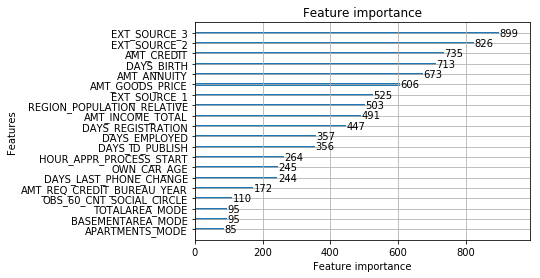

In [35]:
importance = gbm.feature_importance()
feature_name = gbm.feature_name()
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()